# argo box analysis

This notebook will walk through our analysis framework for a single box. I feel like lots of my notes/work are scattered around different notebooks, so I think it will be helpful to organize everything in one place to think through the flow of our analysis and also identify weak points that still need to be examined more closely.

In [1]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
from importlib import reload
from cmocean import cm as cmo
import xrft
import pandas as pd


import density_funcs as df
import EV_funcs as ef
import filt_funcs as ff
import plot_funcs as pf
import MLD_funcs as mf

In [2]:
reload(df)
reload(ef)
reload(ff)
reload(pf)
reload(mf)

<module 'MLD_funcs' from '/home.ufs/amf2288/argo-intern/MLD_funcs.py'>

As I conceptualize it, below are the elements of the analysis that should be included in this notebook:
- plot contours of temperature, salinity, density, and spice
- select a few interesting spice profiles and show filtering and masking techniques
- plot average MLD and profiles by season
- plot average ratio quantities by depth
- plot spectra for whole profile and masks profiles
- plot EKE/MKE binned by both scale and depth respectively (try with whole profile and masked profiles)

## Select and Plot Box

In [3]:
box_z = xr.open_dataset('202206_boxes/lon:(25,30)_lat:(-60,-55)_ds_z.nc')
box_r = xr.open_dataset('202206_boxes/lon:(25,30)_lat:(-60,-55)_ds_rho.nc')

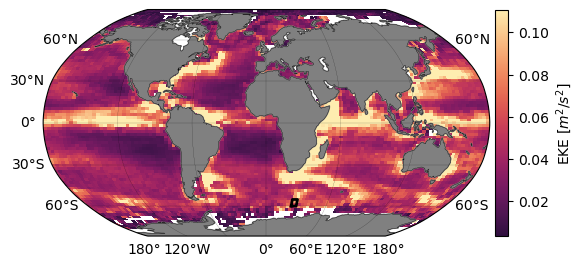

In [4]:
pf.plot_box([[25,30,-60,-55]])

In [60]:
box_z = mf.get_MLD(box_z)
box_z = mf.add_times(box_z)

Text(0.5, 1.0, 'Fractional Months & Years')

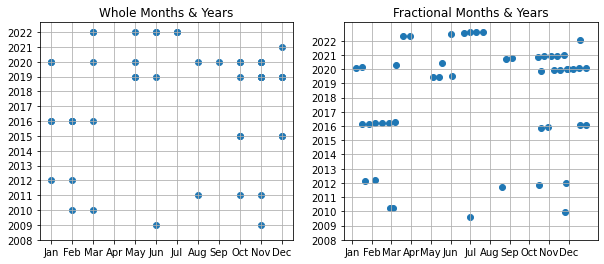

In [65]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(box_z.month,box_z.year)
plt.yticks(range(2008,2023),range(2008,2023))
plt.xticks(range(1,13),months)
plt.grid()
plt.title('Whole Months & Years')

plt.subplot(1,2,2)
plt.scatter(box_z.month_frac,box_z.year_frac)
plt.yticks(range(2008,2023),range(2008,2023))
plt.xticks(range(1,13),months)
plt.grid()
plt.title('Fractional Months & Years')

These plots are so pretty, they make me very happy to look at them for different boxes.

On another note, I chose a small box (5 by 5) because I was hoping that seasonal signals might come out stronger? (ie if hopefully a smaller region would have a cohesive seasonal signal instead of picking up a few different things happening at once.) But now when I see how few profiles we have, I wonder if noise from averaging over limited data will be another difficult problem to work through.

## Plot Tracers and Profiles

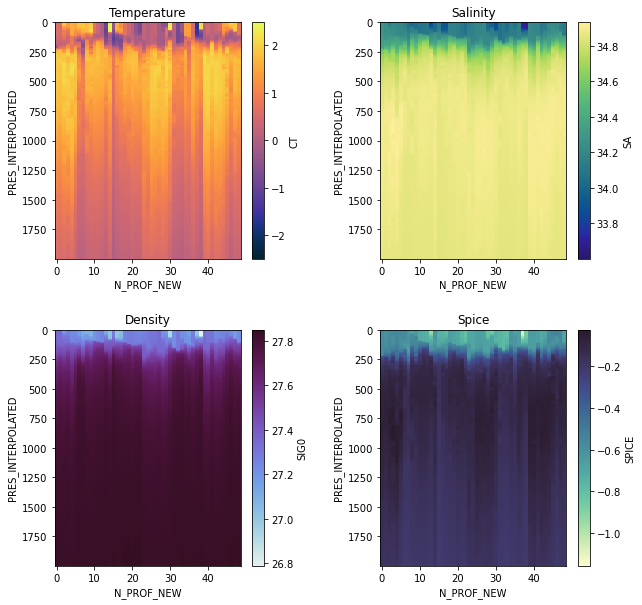

In [22]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
box_z.CT.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',cmap=cmo.thermal)
plt.gca().invert_yaxis()
plt.title('Temperature')

plt.subplot(2,2,2)
box_z.SA.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',cmap=cmo.haline)
plt.gca().invert_yaxis()
plt.title('Salinity')

plt.subplot(2,2,3)
box_z.SIG0.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',cmap=cmo.dense)
plt.gca().invert_yaxis()
plt.title('Density')

plt.subplot(2,2,4)
box_z.SPICE.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',cmap=cmo.deep)
plt.gca().invert_yaxis()
plt.title('Spice')

plt.subplots_adjust(hspace=0.3,wspace=0.4)

any comments to add here? Not really I guess

In [49]:
CT_100 = ff.get_filt_single(box_z,100,'CT')
CT_200 = ff.get_filt_single(box_z,200,'CT')
CT_400 = ff.get_filt_single(box_z,400,'CT')

SA_100 = ff.get_filt_single(box_z,100,'SA')
SA_200 = ff.get_filt_single(box_z,200,'SA')
SA_400 = ff.get_filt_single(box_z,400,'SA')

SIG0_100 = ff.get_filt_single(box_z,100,'SIG0')
SIG0_200 = ff.get_filt_single(box_z,200,'SIG0')
SIG0_400 = ff.get_filt_single(box_z,400,'SIG0')

SPICE_100 = ff.get_filt_single(box_z,100,'SPICE')
SPICE_200 = ff.get_filt_single(box_z,200,'SPICE')
SPICE_400 = ff.get_filt_single(box_z,400,'SPICE')

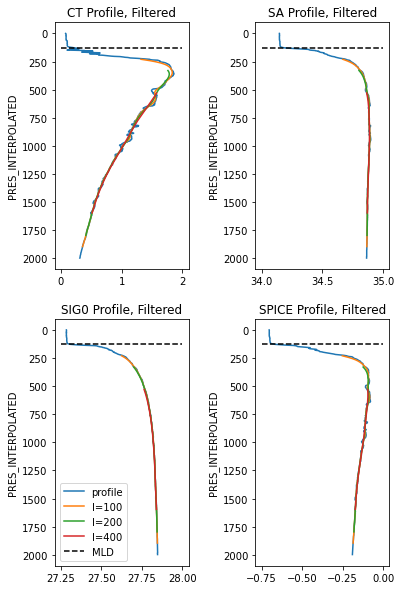

In [58]:
n=20
plt.figure(figsize=(6,10))

plt.subplot(2,2,1)
box_z.CT.isel(N_PROF=n).plot(y='PRES_INTERPOLATED')
CT_100.where(CT_100.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED')
CT_200.where(CT_200.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED')
CT_400.where(CT_400.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED')
plt.hlines(box_z.MLD.isel(N_PROF=n),0,2,color='k',linestyle='--',label='MLD')
plt.gca().invert_yaxis()
plt.title('CT Profile, Filtered')

plt.subplot(2,2,2)
box_z.SA.isel(N_PROF=n).plot(y='PRES_INTERPOLATED')
SA_100.where(CT_100.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED')
SA_200.where(CT_200.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED')
SA_400.where(CT_400.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED')
plt.hlines(box_z.MLD.isel(N_PROF=n),34,35,color='k',linestyle='--',label='MLD')
plt.gca().invert_yaxis()
plt.title('SA Profile, Filtered')

plt.subplot(2,2,3)
box_z.SIG0.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',label='profile')
SIG0_100.where(CT_100.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED',label='l=100')
SIG0_200.where(CT_200.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED',label='l=200')
SIG0_400.where(CT_400.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED',label='l=400')
plt.hlines(box_z.MLD.isel(N_PROF=n),27.25,28,color='k',linestyle='--',label='MLD')
plt.gca().invert_yaxis()
plt.legend()
plt.title('SIG0 Profile, Filtered')

plt.subplot(2,2,4)
box_z.SPICE.isel(N_PROF=n).plot(y='PRES_INTERPOLATED')
SPICE_100.where(CT_100.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED')
SPICE_200.where(CT_200.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED')
SPICE_400.where(CT_400.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED')
plt.hlines(box_z.MLD.isel(N_PROF=n),-0.75,0,color='k',linestyle='--',label='MLD')
plt.gca().invert_yaxis()
plt.title('SPICE Profile, Filtered')

plt.subplots_adjust(wspace=0.5)

I included these profiles mostly to show how the mask works and how much of the profile it removes at certain scales. I still worry that cutting off that much of the profile makes it difficult to draw significant conclusions? Additionally, I'm not sure how the functions I've already written take masking into account, so keep an eye on that as time goes on.

## Plot MLD

In [67]:
SIG0_01 = box_z.SIG0.where(box_z.month<2).dropna('N_PROF')
SIG0_02 = box_z.SIG0.where(box_z.month<3).where(box_z.month>1).dropna('N_PROF')
SIG0_03 = box_z.SIG0.where(box_z.month<4).where(box_z.month>2).dropna('N_PROF')
SIG0_04 = box_z.SIG0.where(box_z.month<5).where(box_z.month>3).dropna('N_PROF')
SIG0_05 = box_z.SIG0.where(box_z.month<6).where(box_z.month>4).dropna('N_PROF')
SIG0_06 = box_z.SIG0.where(box_z.month<7).where(box_z.month>5).dropna('N_PROF')
SIG0_07 = box_z.SIG0.where(box_z.month<8).where(box_z.month>6).dropna('N_PROF')
SIG0_08 = box_z.SIG0.where(box_z.month<9).where(box_z.month>7).dropna('N_PROF')
SIG0_09 = box_z.SIG0.where(box_z.month<10).where(box_z.month>8).dropna('N_PROF')
SIG0_10 = box_z.SIG0.where(box_z.month<11).where(box_z.month>9).dropna('N_PROF')
SIG0_11 = box_z.SIG0.where(box_z.month<12).where(box_z.month>10).dropna('N_PROF')
SIG0_12 = box_z.SIG0.where(box_z.month<13).where(box_z.month>11).dropna('N_PROF')

SIG0_s = [SIG0_01,SIG0_02,SIG0_03,SIG0_04,SIG0_05,SIG0_06,SIG0_07,SIG0_08,SIG0_09,SIG0_10,SIG0_11,SIG0_12]

In [61]:
SPICE_01 = box_z.SPICE.where(box_z.month<2).dropna('N_PROF')
SPICE_02 = box_z.SPICE.where(box_z.month<3).where(box_z.month>1).dropna('N_PROF')
SPICE_03 = box_z.SPICE.where(box_z.month<4).where(box_z.month>2).dropna('N_PROF')
SPICE_04 = box_z.SPICE.where(box_z.month<5).where(box_z.month>3).dropna('N_PROF')
SPICE_05 = box_z.SPICE.where(box_z.month<6).where(box_z.month>4).dropna('N_PROF')
SPICE_06 = box_z.SPICE.where(box_z.month<7).where(box_z.month>5).dropna('N_PROF')
SPICE_07 = box_z.SPICE.where(box_z.month<8).where(box_z.month>6).dropna('N_PROF')
SPICE_08 = box_z.SPICE.where(box_z.month<9).where(box_z.month>7).dropna('N_PROF')
SPICE_09 = box_z.SPICE.where(box_z.month<10).where(box_z.month>8).dropna('N_PROF')
SPICE_10 = box_z.SPICE.where(box_z.month<11).where(box_z.month>9).dropna('N_PROF')
SPICE_11 = box_z.SPICE.where(box_z.month<12).where(box_z.month>10).dropna('N_PROF')
SPICE_12 = box_z.SPICE.where(box_z.month<13).where(box_z.month>11).dropna('N_PROF')

SPICE_s = [SPICE_01,SPICE_02,SPICE_03,SPICE_04,SPICE_05,SPICE_06,SPICE_07,SPICE_08,SPICE_09,SPICE_10,SPICE_11,SPICE_12]

Text(0.5, 1.0, 'Spice Profiles')

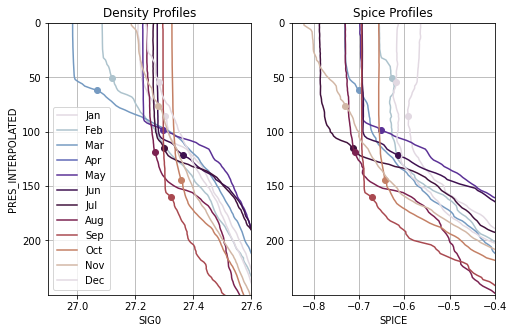

In [79]:
plt.figure(figsize=(8,5))
colors = plt.cm.twilight(np.linspace(0,1,12))

plt.subplot(1,2,1)
for n in range(0,len(SIG0_s)):
    SIG0_mean = SIG0_s[n].mean('N_PROF')
    SIG0_mean.plot(y='PRES_INTERPOLATED',label='{}'.format(months[n]),color=colors[n])
    plt.plot(SIG0_mean.sel(PRES_INTERPOLATED=SIG0_s[n].MLD.mean('N_PROF'),method='nearest'),
             SIG0_s[n].MLD.mean('N_PROF'),marker='o',color=colors[n])

plt.ylim(0,250)
plt.xlim(26.9,27.6)
plt.yticks(range(0,250,50),range(0,250,50))
plt.grid()
plt.gca().invert_yaxis()
plt.legend()
plt.title('Density Profiles')

plt.subplot(1,2,2)
for n in range(0,len(SIG0_s)):
    SPICE_mean = SPICE_s[n].mean('N_PROF')
    SPICE_mean.plot(y='PRES_INTERPOLATED',label='{}'.format(months[n]),color=colors[n])
    plt.plot(SPICE_mean.sel(PRES_INTERPOLATED=SPICE_s[n].MLD.mean('N_PROF'),method='nearest'),
             SPICE_s[n].MLD.mean('N_PROF'),marker='o',color=colors[n])

plt.ylabel('')
plt.ylim(0,250)
plt.xlim(-0.85,-.4)
plt.yticks(range(0,250,50),range(0,250,50))
plt.grid()
plt.gca().invert_yaxis()
plt.title('Spice Profiles')

## Plot Spectra and Ratios

In [81]:
SIG0_spec  = xrft.power_spectrum(box_z.SIG0.mean('N_PROF'), dim='PRES_INTERPOLATED',window='hamming')
SPICE_spec = xrft.power_spectrum(box_z.SPICE.mean('N_PROF'),dim='PRES_INTERPOLATED',window='hamming')
SIG0_m  = SIG0_spec.freq_PRES_INTERPOLATED
SPICE_m = SPICE_spec.freq_PRES_INTERPOLATED

Text(0.5, 1.0, 'Spice Spectra')

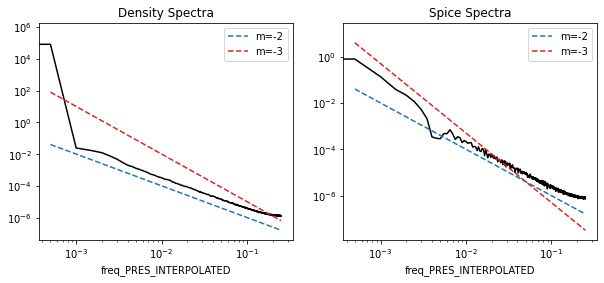

In [96]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
SIG0_spec.plot(color='k')
plt.plot(SIG0_m, 1e-8*SIG0_m**(-2),'--',color='tab:blue',label='m=-2')
plt.plot(SIG0_m, 1e-8*SIG0_m**(-3),'--',color='tab:red', label='m=-3')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Density Spectra')


plt.subplot(1,2,2)
SPICE_spec.plot(color='k')
plt.plot(SPICE_m, 1e-8*SPICE_m**(-2),'--',color='tab:blue',label='m=-2')
plt.plot(SPICE_m, 5e-10*SPICE_m**(-3),'--',color='tab:red', label='m=-3')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Spice Spectra')

This is kind of interesting because it looks like there may be a very subtle break in slope in the spice spectra. At the largest scales it seems to follow a slope of m=-3, but below 100m it's much closer to m=-2. This same pattern is not seen in density.

In [97]:
l1 = 100
l2 = 200
l3 = 400

MKE1_d = ef.get_MV(box_z,l1,variable='SIG0')
MKE2_d = ef.get_MV(box_z,l2,variable='SIG0')
MKE3_d = ef.get_MV(box_z,l3,variable='SIG0')

MKE1_s = ef.get_MV(box_z,l1,variable='SPICE')
MKE2_s = ef.get_MV(box_z,l2,variable='SPICE')
MKE3_s = ef.get_MV(box_z,l3,variable='SPICE')

EKE1_d = ef.get_EV(box_z,l1,variable='SIG0')
EKE2_d = ef.get_EV(box_z,l2,variable='SIG0')
EKE3_d = ef.get_EV(box_z,l3,variable='SIG0')

EKE1_s = ef.get_EV(box_z,l1,variable='SPICE')
EKE2_s = ef.get_EV(box_z,l2,variable='SPICE')
EKE3_s = ef.get_EV(box_z,l3,variable='SPICE')

In [98]:
MKE0_vd = EKE1_d
MKE1_vd = MKE1_d - MKE2_d
MKE2_vd = MKE2_d - MKE3_d
MKE3_vd = MKE3_d

MKE0_vs = EKE1_s
MKE1_vs = MKE1_s - MKE2_s
MKE2_vs = MKE2_s - MKE3_s
MKE3_vs = MKE3_s

EKE0_vd = EKE1_d
EKE1_vd = EKE2_d - EKE1_d
EKE2_vd = EKE3_d - EKE2_d
EKE3_vd = MKE3_d

EKE0_vs = EKE1_s
EKE1_vs = EKE2_s - EKE1_s
EKE2_vs = EKE3_s - EKE2_s
EKE3_vs = MKE3_s

In [112]:
EV_l1_d = ef.get_EV(box_z,l1,variable='SIG0')
MV_l1_d = ef.get_MV(box_z,l1,variable='SIG0')

EV_l2_d = ef.get_EV(box_z,l2,variable='SIG0')
MV_l2_d = ef.get_MV(box_z,l2,variable='SIG0')

EV_l3_d = ef.get_EV(box_z,l3,variable='SIG0')
MV_l3_d = ef.get_MV(box_z,l3,variable='SIG0')


EV_l1_s = ef.get_EV(box_z,l1,variable='SPICE')
MV_l1_s = ef.get_MV(box_z,l1,variable='SPICE')

EV_l2_s = ef.get_EV(box_z,l2,variable='SPICE')
MV_l2_s = ef.get_MV(box_z,l2,variable='SPICE')

EV_l3_s = ef.get_EV(box_z,l3,variable='SPICE')
MV_l3_s = ef.get_MV(box_z,l3,variable='SPICE')

In [114]:
R_l1_d = EV_l1_d.mean('N_PROF') / MV_l1_d.mean('N_PROF')
R_l2_d = EV_l2_d.mean('N_PROF') / MV_l2_d.mean('N_PROF')
R_l3_d = EV_l3_d.mean('N_PROF') / MV_l3_d.mean('N_PROF')

R_l1_s = EV_l1_s.mean('N_PROF') / MV_l1_s.mean('N_PROF')
R_l2_s = EV_l2_s.mean('N_PROF') / MV_l2_s.mean('N_PROF')
R_l3_s = EV_l3_s.mean('N_PROF') / MV_l3_s.mean('N_PROF')

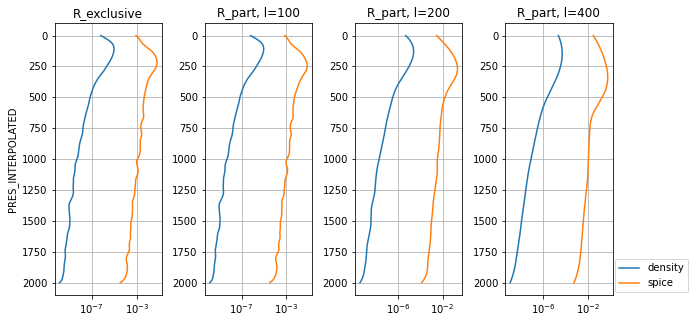

In [130]:
plt.figure(figsize=(10,5))

plt.subplot(1,4,1)
(EKE0_vd.mean('N_PROF') / MKE3_vd.mean('N_PROF')).plot(y='PRES_INTERPOLATED',label='density')
(EKE0_vs.mean('N_PROF') / MKE3_vs.mean('N_PROF')).plot(y='PRES_INTERPOLATED',label='spice')
plt.gca().invert_yaxis()
plt.grid()
plt.xscale('log')
plt.title('R_exclusive')

plt.subplot(1,4,2)
R_l1_d.plot(y='PRES_INTERPOLATED',label='density')
R_l1_s.plot(y='PRES_INTERPOLATED',label='spice')
plt.gca().invert_yaxis()
plt.grid()
plt.xscale('log')
plt.ylabel('')
plt.title('R_part, l={}'.format(l1))

plt.subplot(1,4,3)
R_l2_d.plot(y='PRES_INTERPOLATED',label='density')
R_l2_s.plot(y='PRES_INTERPOLATED',label='spice')
plt.gca().invert_yaxis()
plt.grid()
plt.xscale('log')
plt.ylabel('')
plt.title('R_part, l={}'.format(l2))

plt.subplot(1,4,4)
R_l3_d.plot(y='PRES_INTERPOLATED',label='density')
R_l3_s.plot(y='PRES_INTERPOLATED',label='spice')
plt.gca().invert_yaxis()
plt.grid()
plt.xscale('log')
plt.ylabel('')
plt.legend(bbox_to_anchor=(1.75,0.15))
plt.title('R_part, l={}'.format(l3))

plt.subplots_adjust(wspace=0.4)

A few things to note here:
- As expected, the density ratio is lower for all ratios because they are small-scale variance over large-scale variance, and we would expect density to be strictly striated and spice to have more variation.
- It's interesting to compare the R_part values for different filter scales. While the general shapes are preserved, features become more drawn out and their depths are distorted. I'm especially looking at the peaks in density ~100m and in spice ~250m when l=100 that appear to occur at ~250m and ~400m when l=400.
- Additionally, this is the point where I wonder if I need to incorporate masking as l changes for R_part so the boundary regions aren't visible. Try this out and see how it goes.

## Plot EKE/MKE by Scale and Depth